In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from nxviz.plots import ArcPlot,CircosPlot,MatrixPlot
import re
import datetime as dt

import matplotlib.pyplot as plt

#import plotly for interactive chart
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='richwolff', api_key='v0qPC120X33yPvAMDQXi')
from plotly.graph_objs import *

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

from collections import defaultdict
%matplotlib inline

<h2>Load books into dataframe</h2>

In [2]:
d = defaultdict(list)

strtofind = r'";"'
with open('../data/raw/BX-Books.csv','r',encoding='8859') as file:
    for i,line in enumerate(file):
        d[i] = re.sub(strtofind,'||',line.replace('&amp;','&')).replace('"','').replace('\n','').split('||')
        
books_df = pd.DataFrame(data=list(d.values())[1:],index=list(d.keys())[1:],columns=d[0])
books_df.head()

del d

<H2> Load Users Into DF </H2>

In [3]:
## Load users file and display first 5 rows
users_df = pd.read_csv('../data/raw/BX-Users.csv',sep=';',encoding='8859')
users_df.tail(5)

,User-ID,Location,Age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


<h2>Load User Ratings Of Books</h2>

In [4]:
ratings_df = pd.read_csv('../data/raw/BX-Book-Ratings.csv',sep=';',encoding='8859',dtype={'Book-Rating':np.int}).sort_values('User-ID')
ratings_df.head()

,User-ID,ISBN,Book-Rating
9561,2,0195153448,0
9562,7,034542252,0
9572,8,0771025661,0
9580,8,1881320189,7
9579,8,1575663937,6


In [5]:
print('Unique users with reviews: {}'.format(len(ratings_df['User-ID'].unique())))
print('Unique books with reviews: {}\n'.format(len(ratings_df['ISBN'].unique())))
print('Total number of nodes: {}'.format(len(ratings_df['User-ID'].unique())+len(ratings_df['ISBN'].unique())))
print('Total number of edges: {}'.format(len(ratings_df)))

Unique users with reviews: 105283
Unique books with reviews: 340556

Total number of nodes: 445839
Total number of edges: 1149780


<h2>Users from different parts of the world can have very different book tastes (also books in differnet languages). In an attempt to bring the complexity of this graph down, I'll filter for users in the USA</h2>

In [6]:
usa_users = users_df[(users_df['Location'].str.contains('united states')) |(users_df['Location'].str.contains('usa'))]
ratings_usa = usa_users.set_index('User-ID').join(ratings_df.set_index('User-ID'),how='inner').reset_index().set_index('ISBN').join(books_df.set_index('ISBN'),how='inner').reset_index()

<h2> Splitting the us data into a smaller test set to then visualize how the graph is organized </h2>

In [7]:
ratings_us_training,ratings_us_test = train_test_split(ratings_usa,test_size=.00350,random_state=21)

In [8]:
# Build the graph structure
sample_G = nx.Graph()

books = set(ratings_us_test['ISBN'].unique())
sample_G.add_nodes_from(books,bipartite='books')

#Add user nodes
users = set(ratings_us_test['User-ID'].unique())
sample_G.add_nodes_from(users,bipartite='users')

# Add Meta Data
for i,row in ratings_us_test.iterrows():
    sample_G.node[row['User-ID']]['Age']=row['Age']
    sample_G.node[row['ISBN']]['Book-Title']=row['Book-Title']
    sample_G.node[row['ISBN']]['Book-Author']=row['Book-Author']
    sample_G.node[row['ISBN']]['Publisher']=row['Publisher']
    
    #Add edges during loop
    sample_G.add_edge(row['User-ID'],row['ISBN'],rating=row['Book-Rating'])

In [9]:
# Get bipartite degree_centrality
dcs = nx.bipartite.degree_centrality(sample_G,users)
for n in sample_G.nodes():
    sample_G.node[n]['bipartite_dcs']= dcs[n]

<h2>Using a circos plot, I'm able to to see which users are reading/reviewing which books. It will be separated by bipartite where users will be purple and books will be green, then ordered by degree centrality. <br><br> The goal is to find out the distribution of which users are reading which books</h2>

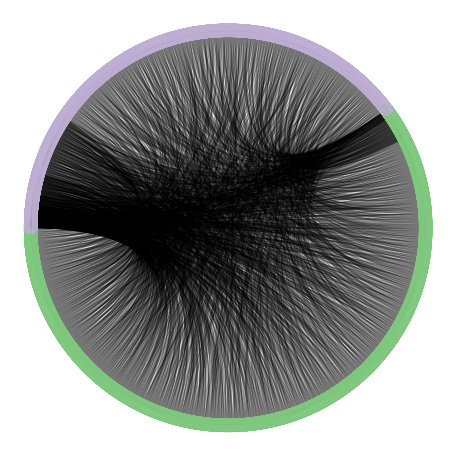

In [10]:
c = CircosPlot(sample_G,
               node_color='bipartite',
               node_order='bipartite_dcs',
               node_grouping='bipartite',
               dpi=300,figsize=(8,8))
c.draw()
plt.savefig('img/circos_sampled_us_users.png',dpi=300,figsize=(8,8))

<h2>Looking at the left side of the users (purple), it seems that a handfull of users are reading the most books. Once you get past the top 20/25%, there seems to be an even distribution of books read among users.<br><br>When looking at the books side, it seems that there are even less books being read by the most users with a sparse distribution of books read for the rest</h2>

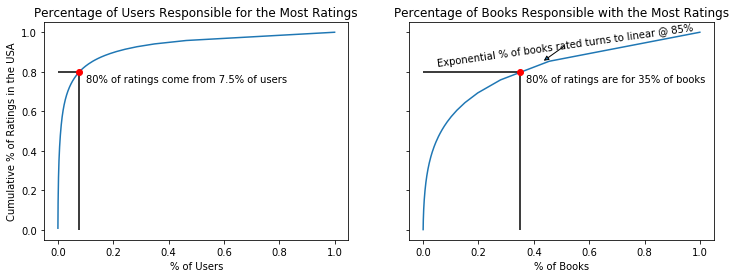

In [11]:
user_y = (ratings_usa['User-ID'].value_counts().cumsum()/len(ratings_usa)).values
user_x = np.arange(1,len(user_y)+1) / len(user_y)

fig,[ax0,ax1] = plt.subplots(1,2,figsize=(12,4),sharey=True);
ax0.plot(user_x,user_y);
ax0.set_ylabel('Cumulative % of Ratings in the USA');
ax0.set_xlabel('% of Users');
ax0.set_title('Percentage of Users Responsible for the Most Ratings');
ax0.vlines(.075,0,0.8);
ax0.hlines(.8,0,.075);
ax0.plot(.075,.8,marker='o',color='red');
ax0.annotate(xy=(.1,.75),s='80% of ratings come from 7.5% of users');

book_y = (ratings_usa['ISBN'].value_counts().cumsum()/len(ratings_usa)).values
book_x = np.arange(1,len(book_y)+1) / len(book_y)

ax1.plot(book_x,book_y);
ax1.set_xlabel('% of Books');
ax1.set_title('Percentage of Books Responsible with the Most Ratings');
xper = .35
ax1.vlines(xper,0,0.8);
ax1.hlines(.8,0,xper);
ax1.plot(xper,.8,marker='o',color='red');
ax1.annotate(xy=(xper+.02,.75),s='80% of ratings are for 35% of books');
ax1.annotate(rotation='8',xytext=(.05,1.01),s='Exponential % of books rated turns to linear @ 85%',xy=(.43,.85),arrowprops={'arrowstyle':'-|>'});
plt.savefig('img/perc_users_ratings.png',dpi=300,figsize=(6,4))

<h2> It looks like most ratings come from a very small % of users while about 80% of ratings ome from 35% of books.  When the books get to 85% of ratings, the exponential trend turns into a linear trend. </h2>

Cumulative % of books by rating count


,% books by rating,# books by rating count
1,0.578598,197045
2,0.753794,59664
3,0.830069,25976
4,0.871490,14106
5,0.897940,9008


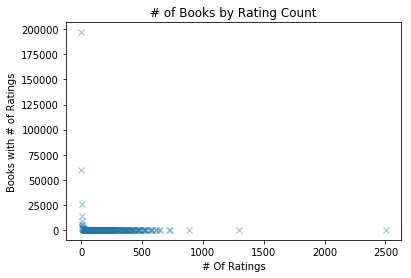

In [12]:
bookratings_valuecounts = pd.DataFrame(ratings_df['ISBN'].value_counts())
#bookratings_valuecounts['cumuper'] = bookratings_valuecounts['ISBN'].cumsum()/len(bookratings_valuecounts)
bookratings_valuecounts['ISBN'].value_counts().plot(linestyle='none',marker='x',alpha=.5)
plt.xlabel('# Of Ratings')
plt.ylabel('Books with # of Ratings')
plt.title('# of Books by Rating Count');
print('Cumulative % of books by rating count')
tmpdf = (bookratings_valuecounts['ISBN'].value_counts()/len(bookratings_valuecounts)).cumsum().to_frame(name='% books by rating')
tmpdf['# books by rating count'] =(bookratings_valuecounts['ISBN'].value_counts())
tmpdf.head()

<h2>Indeed, we see that over 57% of books have 1 ratings. This means they may not give us a lot of of information when using a collaborative filtering recommendation system and we may want to use a content-based filtering recommendation system to extract some usefullness from these books
<BR><BR>
Next, I'll create a projected graph visualization of our users to see how the users may connect to each other</h2>

In [13]:
#Create projected Graphs of users and books
sample_G_users = nx.bipartite.weighted_projected_graph(sample_G,users)
sample_G_books = nx.bipartite.weighted_projected_graph(sample_G,books)

In [14]:
### PLOTLY FUNCITONS
### Usage from work of https://github.com/lgallen/twitter-graph/blob/master/social_graph_plotly.ipynb

def scatter_nodes(G, pos, nodeID, labels=None, color='rgb(152, 0, 0)', size=8, opacity=1):
    # pos is the dict of node positions
    # labels is a list  of labels of len(pos), to be displayed when hovering the mouse over the nodes
    # color is the color for nodes. When it is set as None the Plotly default color is used
    # size is the size of the dots representing the nodes
    # opacity is a value between [0,1] defining the node color opacity

    trace = Scatter(x=[], 
                    y=[],  
                    mode='markers', 
                    marker=Marker(
        #showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='Greens',
        reversescale=True,
        color=[],
        size=10,         
        colorbar=dict(
            thickness=12,
            title='bipartite dcs',
            xanchor='left',
            titleside='right'
        ),
    line=dict(width=2)))
    for nd in nodeID:
        trace['x'].append(pos[nd][0])
        trace['y'].append(pos[nd][1])
        trace['marker']['color'].append(G.nodes(data=True)[nd]['bipartite_dcs'])
    attrib=dict(name='', text=labels , hoverinfo='text', opacity=opacity) # a dict of Plotly node attributes
    trace=dict(trace, **attrib)# concatenate the dict trace and attrib
    trace['marker']['size']=size

    return trace

def scatter_edges(G, pos, line_color='#00FF00', line_width=1, opacity=.2):
    trace = Scatter(x=[], 
                    y=[], 
                    mode='lines',
                   )
    for edge in G.edges(data=True):
        trace['x'] += [pos[edge[0]][0], pos[edge[1]][0], None]
        trace['y'] += [pos[edge[0]][1], pos[edge[1]][1], None]  
        trace['hoverinfo']='none'
        trace['line']['width']=2
        if line_color is not None: # when it is None a default Plotly color is used
            trace['line']['color']=line_color
    return trace

def make_annotations(pos, nodes, text, font_size=14, font_color='rgb(25,25,25)'):
    L=len(pos)
    if len(text)!=L:
        raise ValueError('The lists pos and text must have the same len')
    annotations = Annotations()
    for nd in nodes:
        annotations.append(
            Annotation(
                text="",
                x=pos[nd][0], y=pos[nd][1],
                xref='x1', yref='y1',
                font=dict(color= font_color, size=font_size),
                showarrow=False)
        )
    return annotations

In [15]:
## Create figure for plotly visualization

# set nodes and graph to be used
use_G = sample_G_users
nodes = use_G.nodes()

# Node label information available on hover. Note that some html tags such as line break <br> are recognized within a string.
labels = []

## Get node positions
pos=nx.spring_layout(use_G,k=.2)
nodeID = sorted(nodes)

for nd in nodes:
      labels.append("User Number: "+ str(nd) + 
                    "<br>" + "Age: " + str(use_G.node[nd]['Age']))

#Get traces for plotly
trace1=scatter_edges(use_G, pos)
trace2=scatter_nodes(use_G, pos, nodes,labels=labels)

#Draw figure
width=1000
height=800
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title='User Connections Based On Neighborhooods of Books Read',
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=dict(
        title='Projection of User Nodes and Their Connections',
        titlefont=dict(
        size=14,
        color='#7f7f7f'),
        showline=False,
        showticklabels=False,
        zeroline=False
    ),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])
fig = Figure(data=data, layout=layout)

In [16]:
fig['layout'].update(annotations=make_annotations(pos=pos,nodes=nodes,text=labels))  
py.iplot(fig, filename='users_connected_based_on_neighborhood_of_books_read')

<h2>From what we see in this sample, users with a higher degree centrality are not connected to more users like I thought would be. I'll check the correlation</h2>

In [17]:
d = defaultdict(int)
for usr in sample_G_users:
    d[usr] += len(sample_G_users[usr])

arr = np.empty((len(d),2),dtype=np.int)
for i,(u,v) in enumerate(d.items()):
    arr[i][0] = u
    arr[i][1] = v
    
connectivity = pd.DataFrame(arr,columns=['usr','connected_users_on_books_read'])
connectivity.set_index('usr',inplace=True)
ls = []
for usr,row in connectivity.iterrows():
    ls.append(sample_G.node[usr]['bipartite_dcs'])
connectivity['dcs'] = ls
connectivity.corr().loc['dcs','connected_users_on_books_read']

0.15343657995668342

<h2>There is almost no correlation between how many users are connected to each other and their degree centrality. There may be another metric that is better to track</h2>
<BR>
<h2>Instead of recommending books based on who read books you've read, perhaps we can recommend based on the connectivity of books</h2>

In [18]:
use_G = sample_G_books
nodes = use_G.nodes()
# Node label information available on hover. Note that some html tags such as line break <br> are recognized within a string.
labels = []

## Get node positions
pos=nx.spring_layout(use_G,k=.12)
nodeID = sorted(nodes)

for nd in nodes:
      labels.append("Book Name: "+ str(use_G.node[nd]['Book-Title']) + 
                    "<br>" + "Book-Author: " + str(use_G.node[nd]['Book-Author']) +
                    "<br>" + "Book-Publisher: " + str(use_G.node[nd]['Publisher']))

#Get traces for plotly
trace1=scatter_edges(use_G, pos)
trace2=scatter_nodes(use_G, pos, nodes,labels=labels)
        

In [19]:
width=1000
height=800
axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
          )
layout=Layout(title= 'Book Connections Based On Neighborhoods of Readers',
    font= Font(),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=dict(
        title='Projection of Book Nodes and Their Connections',
        titlefont=dict(
        size=14,
        color='#7f7f7f'),
        showline=False,
        showticklabels=False,
        zeroline=False
    ),
    yaxis=YAxis(axis),
    margin=Margin(
        l=40,
        r=40,
        b=85,
        t=100,
        pad=0,
       
    ),
    hovermode='closest',
    plot_bgcolor='#EFECEA', #set background color            
    )


data=Data([trace1, trace2])

fig = Figure(data=data, layout=layout)

In [20]:
fig['layout'].update(annotations=make_annotations(pos=pos,nodes=nodes,text=labels))  
py.iplot(fig, filename='books_connected_based_on_neighborhood')

<h2>There seems to be many more connections here but the degree centrality is still very low for most which means there may not be a correlation between the two</h2>

In [21]:
# d = defaultdict(int)
for isbn in sample_G_books:
    d[isbn] += len(sample_G_books[isbn])

arr = np.empty((len(d),2),dtype=np.object)
for i,(u,v) in enumerate(d.items()):
    arr[i][0] = u
    arr[i][1] = v
    
connectivity = pd.DataFrame(arr,columns=['isbn','connected_books_on_books_read'])
connectivity.set_index('isbn',inplace=True)

ls = []

for isbn,row in connectivity.iterrows():
    ls.append(sample_G.node[isbn]['bipartite_dcs'])
connectivity['dcs'] = ls
connectivity['connected_books_on_books_read'] = pd.to_numeric(connectivity['connected_books_on_books_read'])
connectivity.corr()

,connected_books_on_books_read,dcs
connected_books_on_books_read,1.00000,0.02265
dcs,0.02265,1.00000


<h2>Indeed there is no correlation. I can still check the betweenness centrality</h2>

In [22]:
# Get bipartite degree_centrality
dcs = nx.bipartite.betweenness_centrality(sample_G,users)
for n in sample_G.nodes():
    sample_G.node[n]['betweenness_centrality']= dcs[n]

In [23]:
d = defaultdict(int)
for isbn in sample_G_books:
    d[isbn] += len(sample_G_books[isbn])

arr = np.empty((len(d),2),dtype=np.object)
for i,(u,v) in enumerate(d.items()):
    arr[i][0] = u
    arr[i][1] = v
    
connectivity = pd.DataFrame(arr,columns=['isbn','connected_books_on_books_read'])
connectivity.set_index('isbn',inplace=True)

ls = []

for isbn,row in connectivity.iterrows():
    ls.append(sample_G.node[isbn]['betweenness_centrality'])
connectivity['betweenness_centrality'] = ls
connectivity['connected_books_on_books_read'] = pd.to_numeric(connectivity['connected_books_on_books_read'])
connectivity.corr()

,connected_books_on_books_read,betweenness_centrality
connected_books_on_books_read,1.000000,0.142907
betweenness_centrality,0.142907,1.000000


In [24]:
d = defaultdict(int)
for usr in sample_G_users:
    d[usr] += len(sample_G_users[usr])

arr = np.empty((len(d),2),dtype=np.int)
for i,(u,v) in enumerate(d.items()):
    arr[i][0] = u
    arr[i][1] = v
    
connectivity = pd.DataFrame(arr,columns=['usr','connected_users_on_books_read'])
connectivity.set_index('usr',inplace=True)
ls = []
for usr,row in connectivity.iterrows():
    ls.append(sample_G.node[usr]['betweenness_centrality'])
connectivity['betweenness_centrality'] = ls
connectivity.corr()

,connected_users_on_books_read,betweenness_centrality
connected_users_on_books_read,1.000000,0.251819
betweenness_centrality,0.251819,1.000000


<h2> We do see an increase in correlation of betweenness centrality and connected users/books. I may focus on this metric for our model</h2>

<h2> As I go into building my model, I'll focus on filtering the books based on the neighborhoods of other books read. If this does not give us a good enough score, I'll potentially try a hybrid approach using both users and books </h2>